In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import confirm.imprint.bound.binomial as binomial
from pyimprint.grid import make_cartesian_grid_range

## Optimizing q for Exponential Holder Bound

In [10]:
def A_cp(n, t):
    return n * cp.sum(cp.logistic(t))


def opt_q_cp(n, theta_0, v, a):
    """
    CVXPY implementation of finding optimal q
    """
    A0 = binomial.A(n, theta_0)
    q = cp.Variable(pos=True)
    objective_fn = ((A_cp(n, theta_0 + (q + 1) * v) - A0) - np.log(a)) / (q + 1)
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    problem.solve(qcp=True)
    return q.value + 1

In [11]:
theta_0 = jnp.array([-2.0, -1.0, 0.3])
n = 350
f0 = 0.025
v = 0.1 * jnp.array([0.4, 1, -1.32])

In [12]:
solver = binomial.ForwardQCPSolver(n)
solve_jit = jax.jit(solver.solve)

In [13]:
%%time
q_opt = solve_jit(theta_0, v, f0)

CPU times: user 148 ms, sys: 3.29 ms, total: 151 ms
Wall time: 150 ms


In [14]:
%%time
q_opt_qcp_cvxpy = opt_q_cp(n, theta_0, v, f0)

CPU times: user 157 ms, sys: 3.15 ms, total: 161 ms
Wall time: 164 ms


/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=

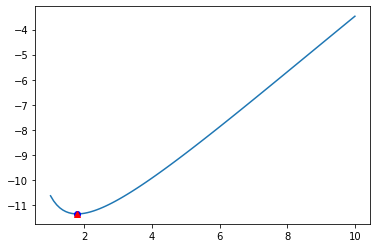

In [15]:
qs = jnp.linspace(1.0001, 10, 100)
phis = np.array([solver.objective(q, theta_0, v, f0) for q in qs])
plt.plot(qs, phis)
plt.plot(q_opt, solver.objective(q_opt, theta_0, v, f0), "bo")
plt.plot(q_opt_qcp_cvxpy, solver.objective(q_opt_qcp_cvxpy, theta_0, v, f0), "r^")

In [18]:
solver = binomial.ForwardQCPSolver(n)
solve_vmap_jit = jax.jit(jax.vmap(solver.solve, in_axes=(0, 0, None)))


def vectorize_run(key, m, d, a=0.025, n=350):
    theta_0 = jax.random.normal(key, (m, d))
    _, key = jax.random.split(key)
    v = 0.001 * jax.random.normal(key, (m, d))
    return solve_vmap_jit(theta_0, v, a)

In [37]:
%%time
qs = vectorize_run(
    jax.random.PRNGKey(10),
    10000,
    3,
)

CPU times: user 871 ms, sys: 5.19 ms, total: 876 ms
Wall time: 873 ms


0


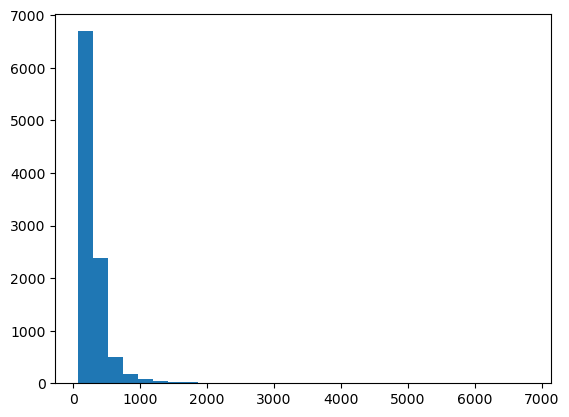

In [45]:
plt.hist(qs[~np.isinf(qs)], bins=30)
print(np.sum(np.isinf(qs)))

## Optimizing q for Implicit Exponential Holder Bound

In [46]:
def qcp_solve_bwd(n, theta_0, v, alpha):
    A0 = binomial.A(n, theta_0)
    shift = (binomial.A(n, theta_0 + v) - A0) + np.log(alpha)
    q = cp.Variable(pos=True)
    objective_fn = ((A_cp(n, theta_0 + (q + 1) * v) - A0) - (q + 1) * shift) / q
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    problem.solve(qcp=True)
    return q.value + 1, problem.value

In [47]:
n = 350
theta_0 = -0.1
v = 0.005
alpha = 0.025

In [48]:
solver_bwd = binomial.BackwardQCPSolver(n)
solve_bwd_jit = jax.jit(solver_bwd.solve)

In [49]:
solve_bwd_vmap_jit = jax.jit(jax.vmap(solver_bwd.solve, in_axes=(0, 0, None)))


def vectorize_run_bwd(key, m, d, a=0.025, n=350):
    theta_0 = jax.random.normal(key, (m, d))
    _, key = jax.random.split(key)
    v = 0.001 * jax.random.normal(key, (m, d))
    return solve_bwd_vmap_jit(theta_0, v, a)

In [50]:
%%time
qs = vectorize_run_bwd(jax.random.PRNGKey(69), 10000, 3)

CPU times: user 2.29 s, sys: 0 ns, total: 2.29 s
Wall time: 1.37 s


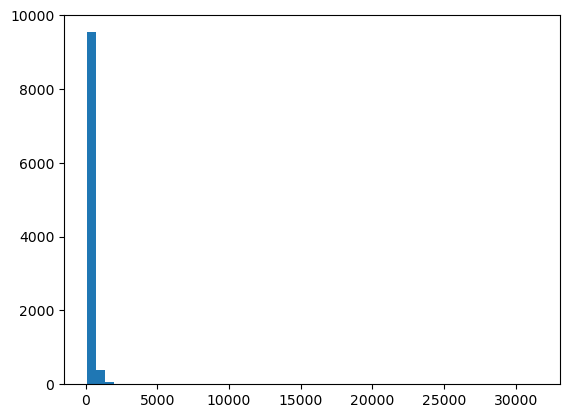

In [51]:
plt.hist(qs, bins=50)
plt.show()

In [52]:
%%time
opt_q = solve_bwd_jit(theta_0, v, alpha)

CPU times: user 763 ms, sys: 0 ns, total: 763 ms
Wall time: 492 ms


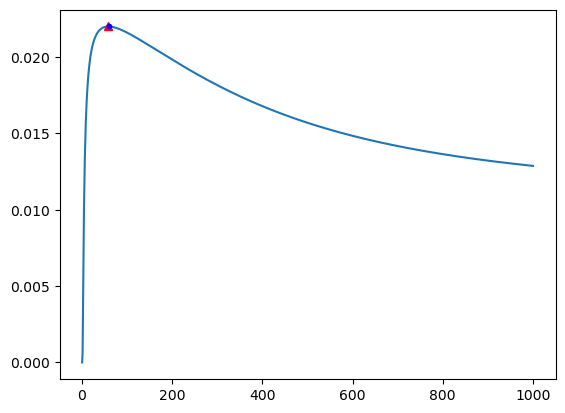

0.021995207 0.021994945


In [53]:
opt_bound = binomial.q_holder_bound_bwd(opt_q, n, theta_0, v, alpha)

# brute force search method
qs = np.linspace(1.01, 1000, 1000)
bound_bwd_f = jax.vmap(binomial.q_holder_bound_bwd, in_axes=(0, None, None, None, None))
bounds = bound_bwd_f(qs, n, theta_0, v, alpha)
i_max = np.argmax(bounds)

# plot
plt.plot(qs, bounds)
plt.plot(qs[i_max], bounds[i_max], "r^")
plt.plot(opt_q, opt_bound, "b.")
plt.show()

print(bounds[i_max], opt_bound)

## Combine Both Forward and Backward

In [54]:
n = 350
theta_0 = -0.1
v = 0.01
alpha = 0.005

In [55]:
# Backward solve the implicit bound at theta_0
solver_bwd = binomial.BackwardQCPSolver(n)
opt_q_bwd = solver_bwd.solve(theta_0, v, alpha)
alpha_prime = binomial.q_holder_bound_bwd(opt_q_bwd, n, theta_0, v, alpha)

# Forward evaluate to get bound on f(theta_0 + v)
bound = binomial.q_holder_bound_fwd(opt_q_bwd, n, theta_0, v, alpha_prime)
bound, alpha, alpha_prime

(DeviceArray(0.005, dtype=float32),
 0.005,
 DeviceArray(0.00367232, dtype=float32))

## Optimize for v

In [56]:
n = 350
theta_0 = -1.0
vs = np.linspace(-1, 1, 100)
bound_vs_f = jax.vmap(binomial.q_holder_bound_fwd, in_axes=(None, None, None, 0, None))
bound_vs = bound_vs_f(2, n, theta_0, vs, f0)

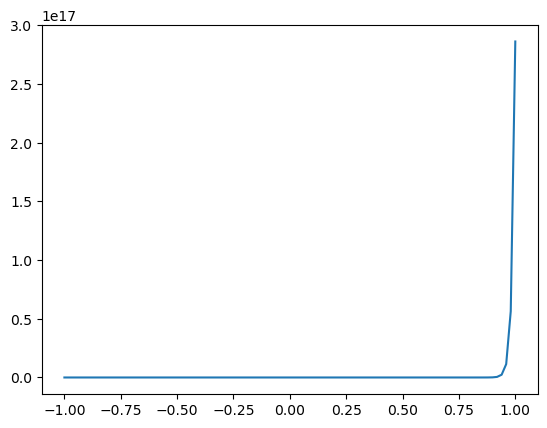

In [57]:
plt.plot(vs, bound_vs)

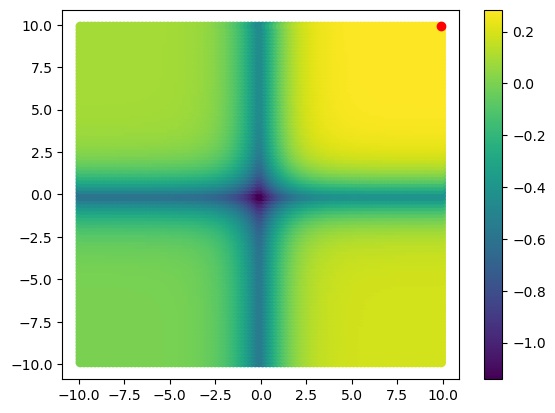

In [58]:
q = 20


def g(v, theta_0, q):
    return jnp.sum(
        binomial.logistic(theta_0 + q * v) / q - binomial.logistic(theta_0 + v)
    )


theta_0 = jnp.array([-0.2, -0.1])
d = theta_0.shape[0]
v_1d_len = 100
vs = (
    make_cartesian_grid_range(v_1d_len, -10 * np.ones(d), 10 * np.ones(d), 0).thetas().T
)
g_vmap = jax.vmap(g, in_axes=(0, None, None))
gs = g_vmap(vs, theta_0, q)

# find max
i_max = jnp.argmax(gs)

sc = plt.scatter(vs[:, 0], vs[:, 1], c=gs)
plt.scatter(vs[i_max, 0], vs[i_max, 1], c="r")
plt.colorbar(sc)
plt.show()

## Tile-based

In [5]:
tile_solver = binomial.TileForwardQCPSolver(
    n=350,
)

In [6]:
theta_0 = jnp.array([-2.0, -1.0, 0.3])
n = 350
f0 = 0.025
radius = 0.05
v_coords = [[-1.0, 1.0]] * theta_0.shape[0]
mgrid = np.meshgrid(*v_coords, indexing="ij")
vs = radius * np.concatenate([coord.reshape(-1, 1) for coord in mgrid], axis=1)

In [7]:
q_opt = tile_solver.solve(theta_0, vs, f0)

0.13139126 0.13139145
3.852435 3.8359573


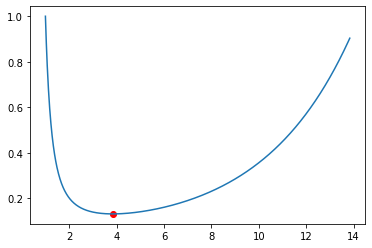

In [9]:
qs = jnp.linspace(1, jnp.maximum(2, q_opt) + 10, 1000)
objs = jax.vmap(
    binomial.tilt_bound_fwd_tile,
    in_axes=(0, None, None, None, None),
)(qs, n, theta_0, vs, f0)
plt.plot(qs, objs)
obj_opt = binomial.tilt_bound_fwd_tile(q_opt, n, theta_0, vs, f0)
plt.scatter(q_opt, obj_opt, color="r")
print(jnp.min(objs), obj_opt)
print(qs[jnp.argmin(objs)], q_opt)

In [10]:
f_opt = jax.jit(
    jax.vmap(
        tile_solver.solve,
        in_axes=(0, None, None),
    )
)
thetas = jnp.repeat(theta_0[None], 10000, axis=0)

In [11]:
%%time
f_opt(thetas, vs, f0)

CPU times: user 567 ms, sys: 6.67 ms, total: 574 ms
Wall time: 571 ms


DeviceArray([3.8359573, 3.8359573, 3.8359573, ..., 3.8359573, 3.8359573,
             3.8359573], dtype=float32)

In [12]:
tile_bwd_solver = binomial.TileBackwardQCPSolver(n=n)

In [13]:
q_opt = tile_bwd_solver.solve(
    theta_0,
    vs,
    f0,
)

0.0028888048 0.0028887917
4.8159523 4.812089


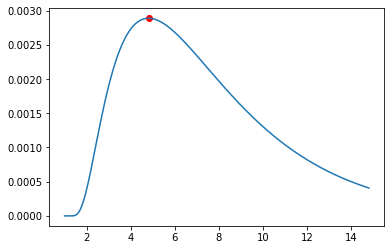

In [14]:
qs = jnp.linspace(1, jnp.maximum(2, q_opt) + 10, 1000)
objs = jax.jit(
    jax.vmap(
        binomial.tilt_bound_bwd_tile,
        in_axes=(0, None, None, None, None),
    )
)(qs, n, theta_0, vs, f0)
plt.plot(qs, objs)
obj_opt = binomial.tilt_bound_bwd_tile(q_opt, n, theta_0, vs, f0)
plt.scatter(q_opt, obj_opt, color="r")
print(jnp.max(objs), obj_opt)
print(qs[jnp.argmax(objs)], q_opt)